# <center>The Smith Parasite - An Unknown Parasitic Disease</center>

A new disease has recently been discovered by Dr. Smith, in England. You have been brought in to investigate.
The disease has already affected more than 5000 people, with no apparent connection between them.

The most common symptoms include fever and tiredness, but some infected people are asymptomatic. Regardless, this virus is being associated with post-disease conditions such as loss of speech, confusion, chest pain and shortness of breath.

The conditions of the transmission of the disease are still unknown and there are no certainties of what leads a patient to suffer or not from it. Nonetheless, some groups of people seem more prone to be infected by the parasite than others.

In this challenge, your goal is to build a predictive model that answers the question, “Who are the people more likely to suffer from the Smith Parasite?”. With that goal, you can access a small quantity of sociodemographic, health, and behavioral information obtained from the patients.

As data scientists, your team is asked to analyze and transform the data available as needed and apply different models to answer the defined question in a more accurate way. Can you build a model that can predict if a patient will suffer, or not, from the Smith Disease?

---

### Datasets
The training set should be used to build your machine learning models. In this set, you also have the ground truth associated to each patient, i.e., if the patient has the disease (Disease = 1) or not (Disease = 0).

The test set should be used to see how well your model performs on unseen data. In this set you don’t have access to the ground truth, and the goal of your team is to predict that value (0 or 1) by using the model you created using the training set.

The score of your predictions is the percentage of instances you correctly predict, using the **f1 score**.

---

### Deliverables

You should submit a csv file with the number of instances in the test set, containing the columns [PatientID, Disease], and only those columns. <br>
The Disease column should contain the prediction (“0” or “1”). Your last solution (the Jupiter notebook) should be submitted on Moodle.

---

In [1]:
import os
import pandas as pd
import numpy as np
import functools
import math
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [2]:
data = {dataset_name.replace('.xlsx', ''): pd.read_excel(f'Data/{dataset_name}') for dataset_name in os.listdir('Data') if 'xlsx' in dataset_name}        

In [3]:
print(list(data.keys()))

['test_demo', 'test_habits', 'test_health', 'train_demo', 'train_habits', 'train_health']


In [4]:
data_frames = [data['train_demo'], data['train_habits'], data['train_health']]
df = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

---
### Exploratory Data Analysis

In [5]:
df.head(5)

,Name,Birth_Year,Region,Education,Disease,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,,,,,,,,,,,
1167,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade),1,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.
1805,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade),1,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.
1557,Mr. Mark Boller,1974,Yorkshire and the Humber,Elementary School (1st to 9th grade),1,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,162,68,226,122,26,0,More than 3 years,Neither I nor my immediate family have diabetes.
1658,Mr. David Caffee,1958,London,University Complete (3 or more years),0,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,180,66,313,125,13,8,Not sure,I have/had pregnancy diabetes or borderline di...
1544,Mr. Gerald Emery,1968,South East,University Incomplete (1 to 2 years),1,No,I consider myself a social drinker,No,1 to 2 pieces of fruit in average,More than half a liter but less than one liter,180,58,277,125,18,2,More than 3 years,I have/had pregnancy diabetes or borderline di...


In [6]:
df.dtypes

Name                object
Birth_Year           int64
Region              object
Education           object
Disease              int64
Smoking_Habit       object
Drinking_Habit      object
Exercise            object
Fruit_Habit         object
Water_Habit         object
Height               int64
Weight               int64
High_Cholesterol     int64
Blood_Pressure       int64
Mental_Health        int64
Physical_Health      int64
Checkup             object
Diabetes            object
dtype: object

In [7]:
pd.concat([df.isnull().sum(),df.eq('').sum()],keys=['Nulls','Empty Strings'],axis=1)

,Nulls,Empty Strings
Name,0,0
Birth_Year,0,0
Region,0,0
Education,13,0
Disease,0,0
Smoking_Habit,0,0
Drinking_Habit,0,0
Exercise,0,0
Fruit_Habit,0,0
Water_Habit,0,0


In [8]:
df.duplicated().sum()

0

In [9]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,800,799,Mr. Gary Miller,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birth_Year,800.0,NaN,NaN,NaN,1966.04375,15.421872,1855.0,1961.0,1966.0,1974.0,1993.0
Region,800,10,East Midlands,154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,787,6,University Complete (3 or more years),239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disease,800.0,NaN,NaN,NaN,0.51375,0.500124,0.0,0.0,1.0,1.0,1.0
Smoking_Habit,800,2,No,673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drinking_Habit,800,3,I usually consume alcohol every day,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise,800,2,No,536,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fruit_Habit,800,5,Less than 1. I do not consume fruits every day.,452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water_Habit,800,3,Between one liter and two liters,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN


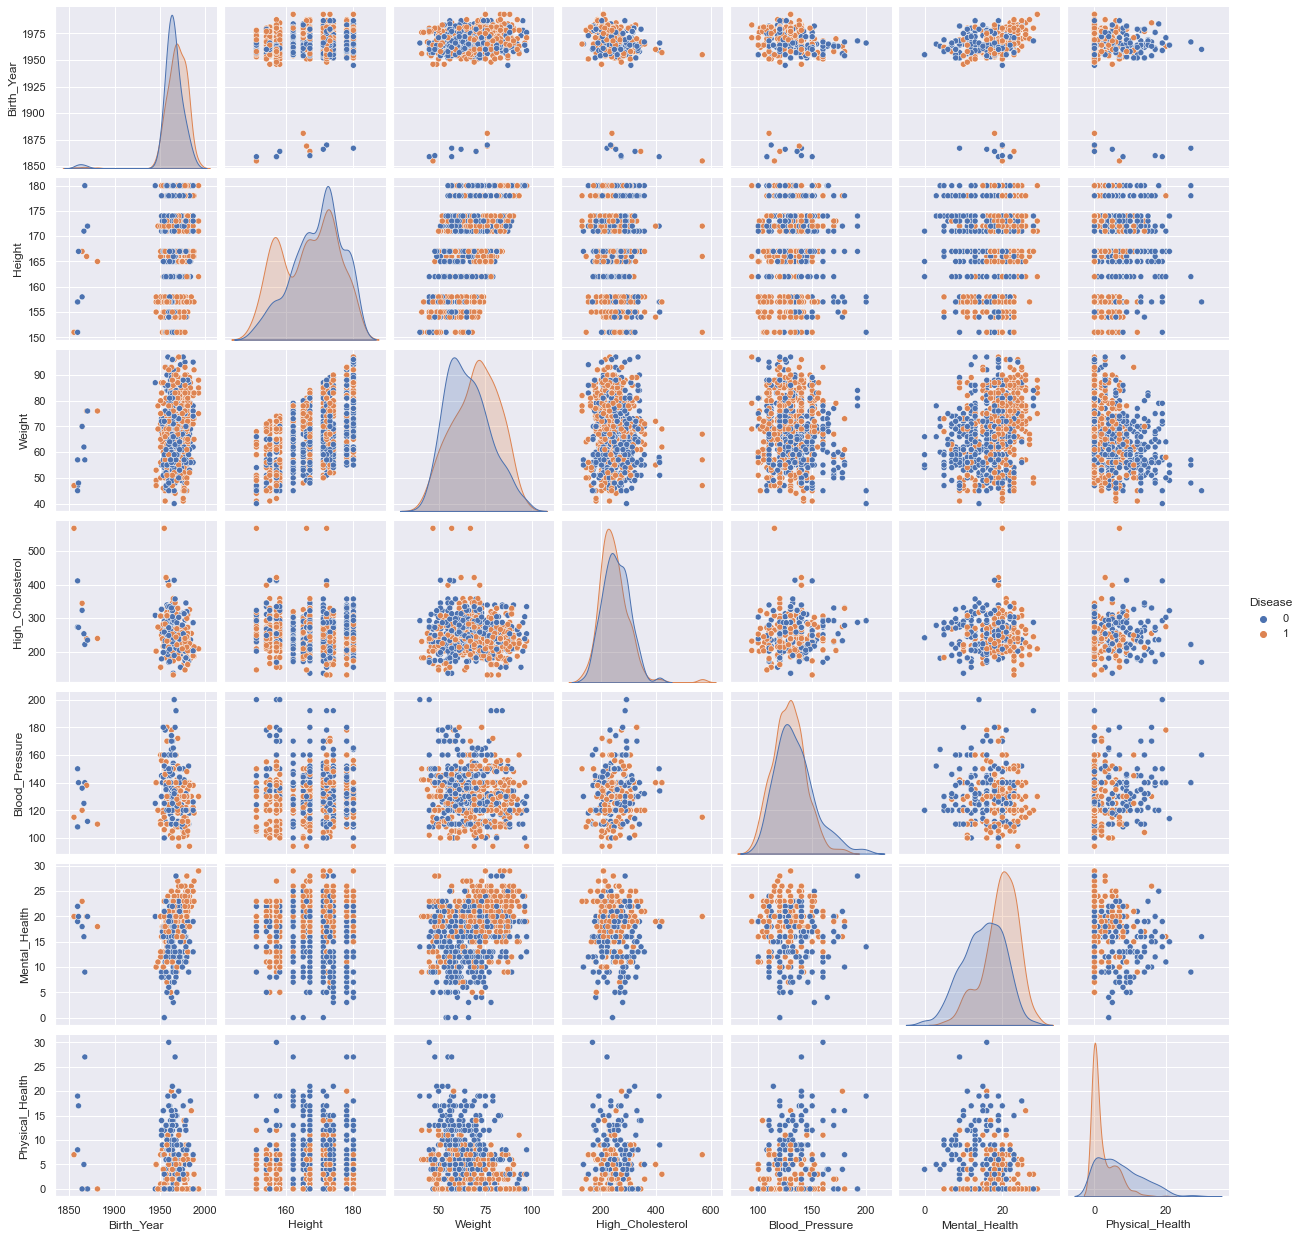

In [23]:
sns.set()

sns.pairplot(df, hue = 'Disease')

In [29]:
fig, ax = plt.subplots(math.ceil(len(df.select_dtypes(include = np.number).columns)/4),4, figsize = (15,10))
# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(ax.flatten(), df.select_dtypes(include = np.number).columns): # Notice the zip() function and flatten() method
    ax.boxplot(df[feat], notch=True, patch_artist=True, colors='red')
    ax.set_title(feat)
    
title = 'Numeric Variables\' Box Plots' # notice the "\"

plt.show()

TypeError: Axes.boxplot() got an unexpected keyword argument 'colors'

---
### Baseline
- only numeric features

In [ ]:
x, y = df.drop(columns = ['Disease']), df['Disease']

In [ ]:
xnumeric = x.select_dtypes(include = np.number)

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(xnumeric, y, random_state = 123 ,test_size = 0.3, shuffle = True , stratify = y)

In [ ]:
model = LogisticRegression(max_iter = 500)
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

print(classification_report(yval, ypred))

In [ ]:
model = RandomForestClassifier()
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

print(classification_report(yval, ypred))

---
### Preprocessing
- Impute
- One-Hot-Encoding
- Scale

In [ ]:
def preprocessing(X):

    #impute missing values in column "Education" with mode
    x['Education'].fillna(x['Education'].mode()[0], inplace=True)

    #split x in numeric and categorical features
    xnumeric, xcategorical = x.select_dtypes(include = np.number), x.select_dtypes(exclude = np.number)

    #One-hot-encoding categorical features
    #drop column "Name" 
    xcategorical.drop(columns = ['Name'], inplace = True)
    x_cat_encoded = pd.concat([pd.get_dummies(xcategorical[col], prefix=col) for col in xcategorical.columns], axis = 1)

    #Scale numeric features
    scaler = MinMaxScaler()
    x_num_scaled = pd.DataFrame(scaler.fit_transform(xnumeric), index = xnumeric.index ,columns = xnumeric.columns)

    xpreprocessed = pd.concat([x_num_scaled, x_cat_encoded], axis = 1)

    return xpreprocessed, x_num_scaled

In [ ]:
xpreprocessed, x_num_scaled = preprocessing(x)

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(xpreprocessed, y, random_state = 321 ,test_size = 0.3, shuffle = True , stratify = y)

In [ ]:
model = RandomForestClassifier()
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

print(classification_report(yval, ypred))

---

### Feature Selection
- reduce noise

In [ ]:
correlation = pd.concat([xnumeric, y], axis = 1).corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
def recursive_feature_elimination(nr_of_features, model, xtrain, xval, ytrain, yval):
    score_lst = []
    feature_lst = []
    high_score = 0
    optimum_nr_of_features = 0

    for i in list(range(1,nr_of_features)):
        model = model
        rfe = RFE(model, n_features_to_select = i)
        xtrain_rfe = rfe.fit_transform(xtrain, ytrain)
        xval_rfe = rfe.transform(xval)
        model.fit(xtrain_rfe, ytrain)

        score = model.score(xval_rfe,yval)
        score_lst.append(score)

        if(score > high_score):
            high_score = score
            optimum_nr_of_features = i
            feature_lst.append(pd.Series(rfe.support_, index = xtrain.columns))

    print(f'Optimum number of features: {optimum_nr_of_features}')
    print(f'Score with {optimum_nr_of_features} features: {high_score}')

    return feature_lst

In [ ]:
res = recursive_feature_elimination(len(xtrain), RandomForestClassifier(), xtrain, xval, ytrain, yval)

In [ ]:
for x in res: print(res)